In [1]:
from keras.layers import Input, Dense, Flatten, Reshape
from sklearn.feature_extraction import image as sk_image
from keras.models import Model
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import convolve2d
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from pyhdf.SD import SD, SDC
import matplotlib as mpl
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d

from mpl_toolkits.basemap import Basemap, cm

2023-09-05 13:23:09.740551: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-05 13:23:09.741907: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 13:23:09.771161: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 13:23:09.771469: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 13:23:10.340094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [95]:
class SobelFilterLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        sobel_x = tf.image.sobel_edges(inputs)[:, :, :, :, 0]  # Sobel filter along x-axis
        sobel_y = tf.image.sobel_edges(inputs)[:, :, :, :, 1]  # Sobel filter along y-axis
        sobel = tf.sqrt(sobel_x**2 + sobel_y**2)
        return sobel


class SimpleAutoencoder:
    def __init__(self, n_vars, patch_size, patch_size_2=None):
        self.n_vars = n_vars
        self.patch_size = patch_size
        if patch_size_2 == None:
            self.patch_size_2 = self.patch_size
        else:
            self.patch_size_2 = patch_size_2
    
    
    def extract_patches(self, image):     
        if image.ndim == 3:
            image = np.expand_dims(image, axis=0)
        else:
            assert image.ndim == 4, "Image has wrong shape. Epected dimension 4, has dimension %s" %image.ndim 
        sizes = [1, self.patch_size, self.patch_size_2, 1]
        strides = [1, self.patch_size, self.patch_size_2, 1]
        rates = [1, 1, 1, 1]
        padding = 'VALID'  # 'VALID' ensures no padding and might discard right/bottom parts of the image if not fitting exactly
        patches = tf.image.extract_patches(images=image,
                                        sizes=sizes,
                                        strides=strides,
                                        rates=rates,
                                        padding=padding)

        # Reshaping the tensor for easier indexing of patches
        return tf.reshape(patches, (-1, self.patch_size, self.patch_size_2, image.shape[-1]))


    def encode(self):
        #encoder_input = keras.Input(shape=(patch_size, patch_size, 1))
        self.encoder_input = keras.Input(shape=(self.patch_size, self.patch_size_2, self.n_vars)) 
        x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(self.encoder_input)
        x = keras.layers.MaxPooling2D((2, 2))(x)

        x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = keras.layers.MaxPooling2D((2, 2))(x)

        x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = keras.layers.MaxPooling2D((2, 2))(x)
        
        x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        self.encoded = keras.layers.MaxPooling2D((2, 2))(x)
        self.encoder = keras.Model(self.encoder_input, self.encoded)

    def decode(self):
        decoder_input = keras.Input(shape=(self.encoded.shape[1], self.encoded.shape[2], self.encoded.shape[3]))
        x = keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(decoder_input)
        x = keras.layers.UpSampling2D((2, 2))(x)
        #x = SobelFilterLayer()(x)
        x = keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
        x = keras.layers.UpSampling2D((2, 2))(x)
        
        x = keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
        x = keras.layers.UpSampling2D((2, 2))(x)

        x = keras.layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
        x = keras.layers.UpSampling2D((2, 2))(x)
        
        # Final layer to get back to original depth
        decoded = keras.layers.Conv2DTranspose(self.n_vars, (3, 3), activation='sigmoid', padding='same')(x)

        self.decoder = keras.Model(decoder_input, decoded)


    def fit(self, datasets, epochs, batch_size, loss="mse", threshold = 0.1, predict_self=False):
        normalized_datasets = self.normalize(datasets)
        all_patches = []

        for image in normalized_datasets:
            patches = self.extract_patches(image)  # Assuming this function extracts and reshapes patches for a single image
            
            # Filter the patches for the current image
            mask = np.mean(patches, axis=(1,2,3)) > threshold
            filtered_patches = patches[mask]

            all_patches.append(filtered_patches)

        # Stack filtered patches from all images
        self.patches = np.concatenate(all_patches, axis=0)

        print(self.patches.shape)
        #self.patches = self.extract_patches(normalized_datasets)
        self.encode()
        self.decode()
        if loss == "mse":
            loss_func = "mse"
        elif loss=="combined":
            loss_func = self.combined_loss
        self.autoencoder = keras.Model(self.encoder_input, self.decoder(self.encoded))
        self.autoencoder.compile(optimizer='adam', loss=loss_func)  # Using combined loss
        self.autoencoder.fit(self.patches, self.patches, epochs=epochs, batch_size=batch_size)

        if predict_self:
            self.predict()


    def normalize(self, data):
        normalized_data = (data - np.nanmin(data, axis=(1,2), keepdims=True)) / (np.nanmax(data, axis=(1,2), keepdims=True) - np.nanmin(data, axis=(1,2), keepdims=True))
        return normalized_data
    
    def predict(self, datasets):
        if datasets.shape[1] != self.patch_size and datasets.shape[2] != self.patch_size_2:
            patches = self.extract_patches(datasets)
        else:
            patches = datasets 

        return self.autoencoder.predict(patches)
    
        
        
    def sobel_loss(self, y_true, y_pred):
        sobel_true = tf.image.sobel_edges(y_true)
        sobel_pred = tf.image.sobel_edges(y_pred)

        # Compute L2 (MSE) loss on Sobel-filtered images
        sobel_loss = tf.reduce_mean(tf.square(sobel_true - sobel_pred))

        return sobel_loss
    
    def combined_loss(self, y_true, y_pred, alpha=0.5):
        # MSE or L2 loss
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # Sobel loss
        sbl_loss = self.sobel_loss(y_true, y_pred)
        
        return mse + alpha * sbl_loss

    def kmeans(self, n_clusters=10, data_shape=(2030, 1354)):
        encoded_patches = self.encoder.predict(self.patches)

        # Flatten the encoded patches for clustering
        self.encoded_patches_flat = encoded_patches.reshape(encoded_patches.shape[0], -1)

        # KMeans clustering
        kmeans = KMeans(n_clusters).fit(self.encoded_patches_flat)
        labels = kmeans.labels_
        # Assuming your original data shape is (height, width)
        height, width = data_shape

        # Calculate the dimensions of the reduced resolution array
        reduced_height = height // self.patch_size
        reduced_width = width // self.patch_size_2

        cluster_map = np.reshape(labels, (reduced_height, reduced_width))
        return cluster_map
    
    def clustering_agglomerative(self, n_clusters=2, affinity='euclidean', linkage='ward', data_shape=(2030, 1354)):
        """
        Clusters the encoded patches using Agglomerative Hierarchical Clustering.
        
        Parameters:
        - n_clusters: The number of clusters to find.
        - affinity: Metric used to compute linkage. Can be “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”.
        - linkage: Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation.
        
        Returns:
        - A 2D array of cluster labels.
        """
        agglomerative = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
        labels = agglomerative.fit_predict(self.encoded_patches_flat)

        # Assuming your original data shape is (height, width)
        height, width = data_shape

        # Calculate the dimensions of the reduced resolution array
        reduced_height = height // self.patch_size
        reduced_width = width // self.patch_size_2

        cluster_map = np.reshape(labels, (reduced_height, reduced_width))
        return cluster_map



In [96]:
folder = "/home/filip/Documents/master_project/training_set/data/"
all_files = os.listdir(folder)
dataset = np.load(folder + all_files[0])
dataset_1 = np.load(folder + all_files[1])
dataset_2 = np.load(folder + all_files[2])
dataset_3 = np.load(folder + all_files[3])
dataset_4 = np.load(folder + all_files[4])
dataset_5 = np.load(folder + all_files[5])
dataset_6 = np.load(folder + all_files[6])
dataset_7 = np.load(folder + all_files[7])


data_list = [dataset, dataset_1, dataset_2, dataset_3, dataset_4, dataset_5, dataset_6, dataset_7]
#data_list = [dataset_5, dataset_2]#, dataset_1, dataset_2, dataset_3, dataset_4, dataset_5, dataset_6, dataset_7]
#min_shape = np.min([data.shape[0] for data in data_list]), np.min([data.shape[1] for data in data_list])
X = np.zeros((len(data_list), 2030, 1354, 1))

for i in range(len(data_list)):
    data_list[i] = np.nan_to_num(data_list[i][:2030, :1354], nan=-1)
    X[i] = np.expand_dims(data_list[i][:2030, :1354], axis=2) #[:min_shape[0], :min_shape[1]])


#print(X.shape)

# autoencoder = SimpleAutoencoder(1, 128, 128)
# autoencoder.fit(X, epochs=50, batch_size=16)
import time
autoencoder2 = SimpleAutoencoder(1, 128, 128)
start = time.time()
autoencoder2.fit(X, epochs=100, batch_size=32, threshold=0.09,loss="combined")
end = time.time()
print("Time used to train", end-start)
# print(X[0].shape)
# #autoencoder = simple_autoencoder([data_01], patch_size)
# autoencoder = simple_autoencoder(1, (2040, 1354), patch_size)    
# autoencoder.fit(X, epochs=5, batch_size=256)

(820, 128, 128, 1)
Epoch 1/100
26/26 [==============================] - 3s 92ms/step - loss: 0.0690
Epoch 2/100
26/26 [==============================] - 2s 93ms/step - loss: 0.0545
Epoch 3/100
26/26 [==============================] - 3s 97ms/step - loss: 0.0508
Epoch 4/100
26/26 [==============================] - 3s 107ms/step - loss: 0.0463
Epoch 5/100
26/26 [==============================] - 3s 108ms/step - loss: 0.0450
Epoch 6/100
26/26 [==============================] - 3s 105ms/step - loss: 0.0450
Epoch 7/100
26/26 [==============================] - 3s 102ms/step - loss: 0.0441
Epoch 8/100
26/26 [==============================] - 3s 110ms/step - loss: 0.0434
Epoch 9/100
10/26 [==========>...................] - ETA: 1s - loss: 0.0451

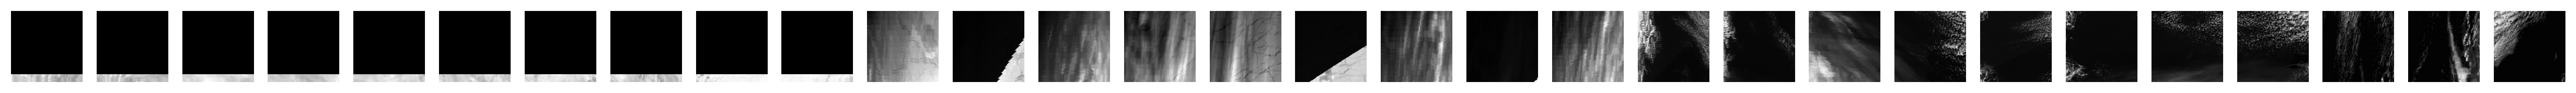

In [94]:
mask = np.mean(autoencoder2.patches, axis=(1,2,3)) > 0.1

test = autoencoder2.patches[~mask]
n_test = test.shape[0]

fig, axs = plt.subplots(1, n_test, figsize = [30, 3], dpi=250)
for i in range(n_test):
    axs[i].imshow(test[i, :, :, 0], cmap="gray")
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].axis('off')


5/5 [==============================] - 0s 34ms/step


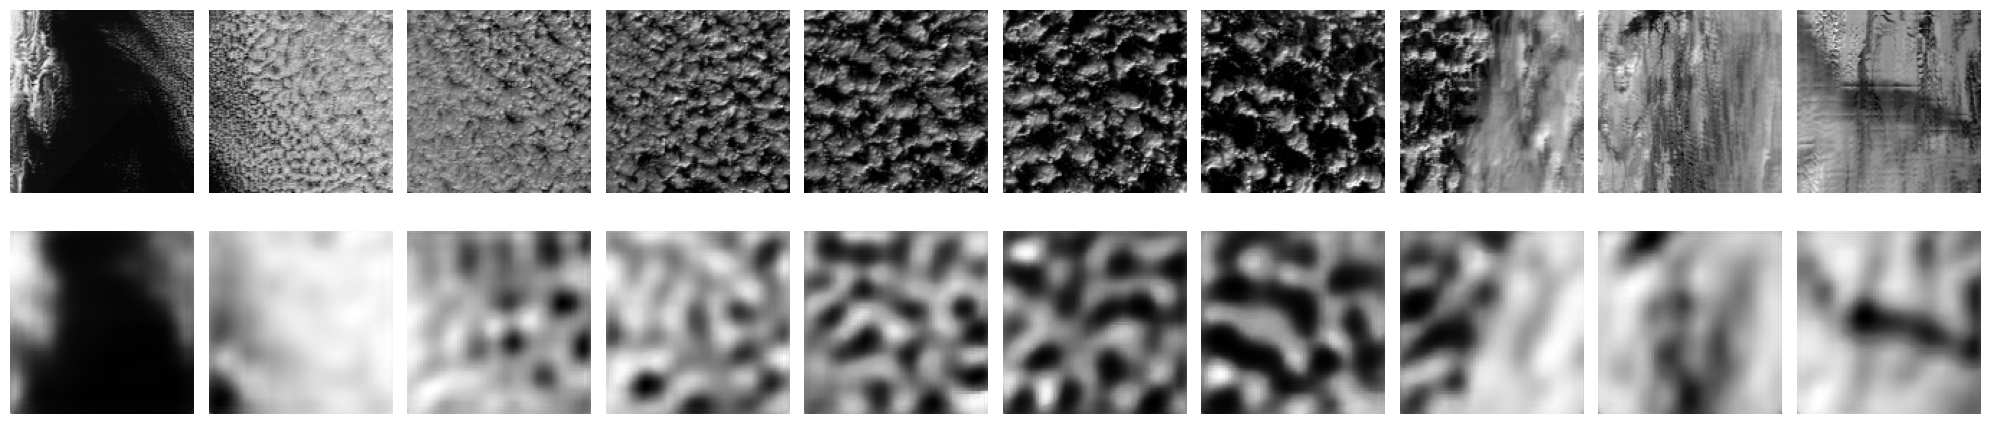

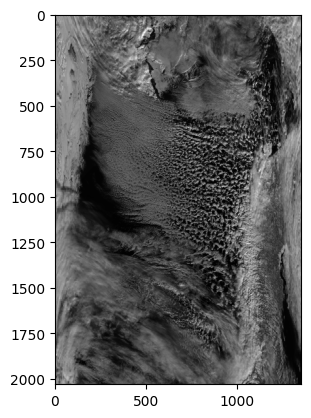

In [19]:
# patches_predict = autoencoder.extract_patches(dataset_5.reshape((1,dataset_5.shape[0], dataset_5.shape[1], 1)))
# predict = autoencoder.autoencoder.predict(patches_predict)
# predict.shape

# #for i in range(83, 90, 2):
# pictures = 12
# patch_start = 68
# fig, axs = plt.subplots(2, pictures, figsize=[pictures*2,5])
# i=0
# for patch_number in range(patch_start, patch_start+pictures):
#     axs[0, i].imshow(patches_predict[patch_number], cmap="gray")
#     axs[1, i].imshow(predict[patch_number,:,:,0], cmap="gray")
    
#     # Turn off ticks and axis labels for both x and y
#     axs[0, i].set_yticks([])
#     axs[0, i].set_xticks([])
#     axs[0, i].axis('off')
    
#     axs[1, i].set_yticks([])
#     axs[1, i].set_xticks([])
#     axs[1, i].axis('off')
    
#     i += 1
# plt.tight_layout()

patches_predict = autoencoder2.extract_patches(dataset_5.reshape((1,dataset_5.shape[0], dataset_5.shape[1], 1)))
predict = autoencoder2.autoencoder.predict(patches_predict)
predict.shape

#for i in range(83, 90, 2):
pictures = 10
patch_start = 61
fig, axs = plt.subplots(2, pictures, figsize=[pictures*2,5])
i=0
for patch_number in range(patch_start, patch_start+pictures):
    axs[0, i].imshow(patches_predict[patch_number], cmap="gray")
    axs[1, i].imshow(predict[patch_number,:,:,0], cmap="gray")
    
    # Turn off ticks and axis labels for both x and y
    axs[0, i].set_yticks([])
    axs[0, i].set_xticks([])
    axs[0, i].axis('off')
    
    axs[1, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].axis('off')
    
    i += 1
plt.tight_layout()

plt.figure()
plt.imshow(dataset_5, cmap='gray')

NameError: name 'labels_img' is not defined

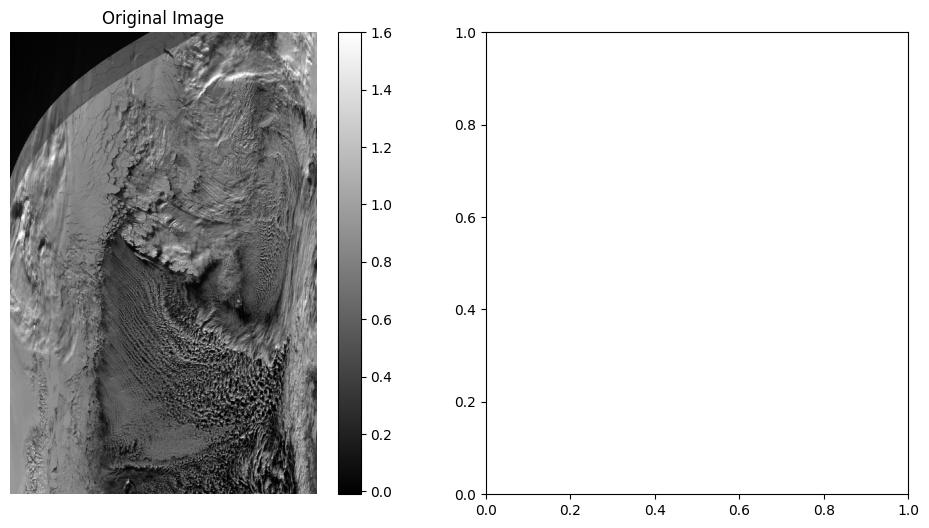

In [6]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

cmp = axes[0].imshow(dataset_2, cmap='gray')
plt.colorbar(cmp, ax=axes[0])
axes[0].set_title('Original Image')
axes[0].axis('off')

cmp = axes[1].imshow(labels_img, cmap='tab10')
plt.colorbar(cmp, ax=axes[1])
axes[1].set_title('Clustered Image')
axes[1].axis('off')

plt.show()

64/64 [==============================] - 0s 785us/step
(2030,)


/home/filip/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


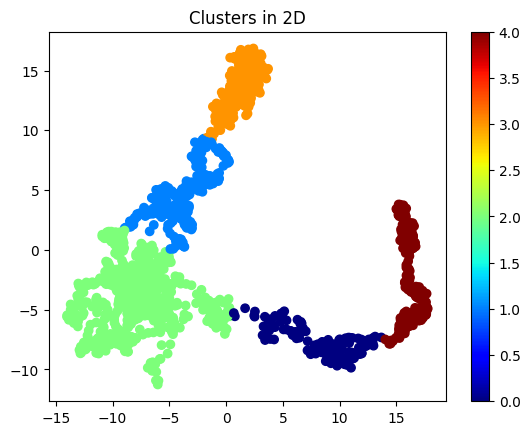

In [ ]:
encoder = Model(flattened_input, encoded)
encoded_imgs = encoder.predict(data)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Reduce the encoded images to 2D using PCA
pca = PCA(n_components=2)
encoded_imgs_2d = pca.fit_transform(encoded_imgs)

# Now cluster the 2D encoded images
n_clusters = 5  # Define the number of clusters you want
kmeans = KMeans(n_clusters=n_clusters)
cluster_assignments = kmeans.fit_predict(encoded_imgs_2d)

print(cluster_assignments.shape)

# If you want to visualize the clusters using matplotlib:
plt.scatter(encoded_imgs_2d[:, 0], encoded_imgs_2d[:, 1], c=cluster_assignments, cmap='jet')
plt.colorbar()
plt.title('Clusters in 2D')
plt.show()


64/64 [==============================] - 0s 1ms/step


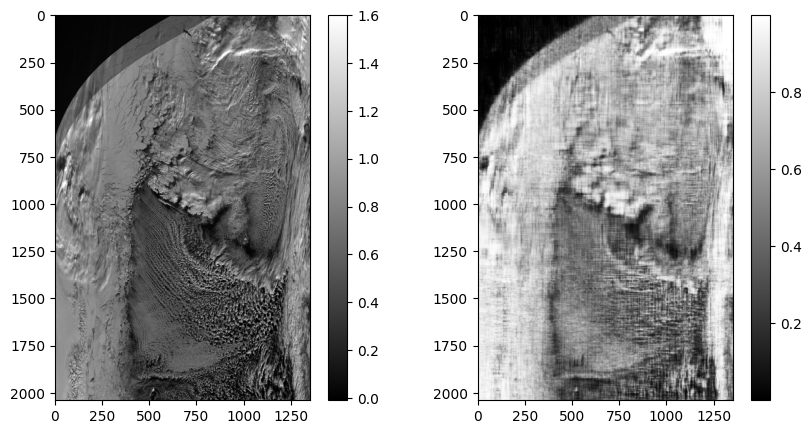

In [ ]:
decoded_imgs = autoencoder.predict(dataset_2)
fig, axs = plt.subplots(1, 2, figsize=[10,5])

cmp = axs[0].imshow(dataset_2, cmap="gray")
plt.colorbar(cmp)
cmp = axs[1].imshow(decoded_imgs,cmap="gray")
plt.colorbar(cmp)

#decoded_imgs_2d = decoded_imgs.reshape((-1, *input_shape))
# plt.contourf(decoded_imgs_2d)
# plt.show(


/home/filip/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


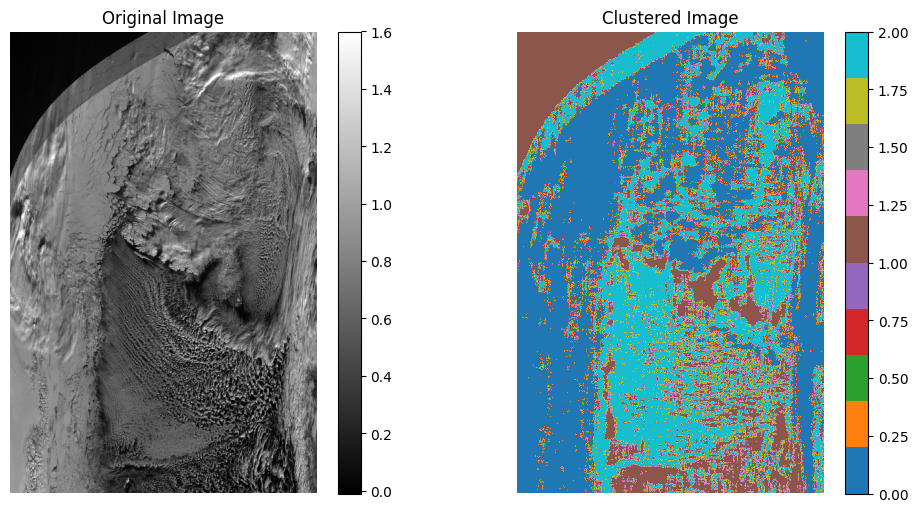

In [ ]:
decoded_imgs_reshaped = decoded_imgs.reshape(-1, 1)

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(decoded_imgs_reshaped)
labels = kmeans.labels_
labels_reshaped = labels.reshape(2040, 1354)

# Assuming `original_img` is your original image
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

cmp = axes[0].imshow(dataset_2, cmap='gray')  # or just cmap depending on the nature of your image
plt.colorbar(cmp)
axes[0].set_title('Original Image')
axes[0].axis('off')

cmp = axes[1].imshow(labels_reshaped, cmap='tab10')  # 'tab10' is a colormap with distinct colors
plt.colorbar(cmp)
axes[1].set_title('Clustered Image')
axes[1].axis('off')

plt.show()


/home/filip/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


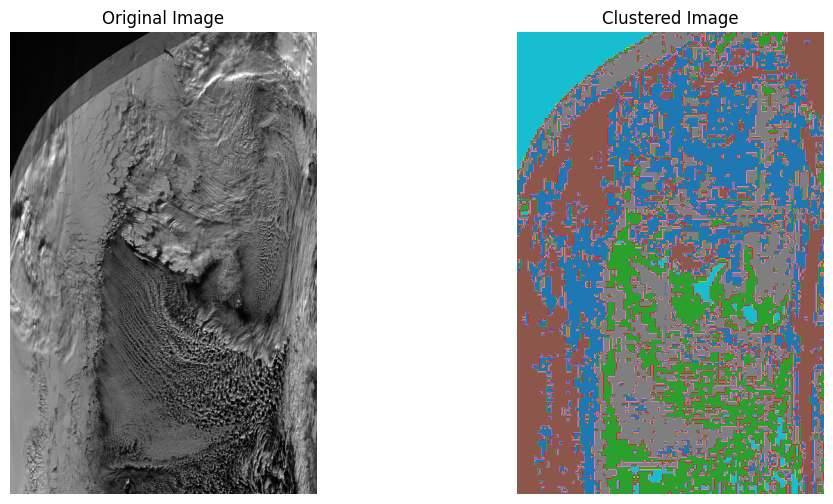

In [ ]:

# Parameters
block_size = (10, 10)  # Change accordingly
n_clusters = 5

# Divide the image into blocks and calculate the mean for each block
blocks = []
for i in range(0, decoded_imgs.shape[0], block_size[0]):
    for j in range(0, decoded_imgs.shape[1], block_size[1]):
        block = decoded_imgs[i:i+block_size[0], j:j+block_size[1]]
        block_mean = np.mean(block)
        blocks.append(block_mean)

blocks = np.array(blocks).reshape(-1, 1)

# Cluster the blocks
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(blocks)
labels = kmeans.labels_

# Construct the clustered image
clustered_img = np.zeros_like(decoded_imgs)
label_idx = 0
for i in range(0, decoded_imgs.shape[0], block_size[0]):
    for j in range(0, decoded_imgs.shape[1], block_size[1]):
        clustered_img[i:i+block_size[0], j:j+block_size[1]] = labels[label_idx]
        label_idx += 1

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Assuming `original_img` is your original image
axes[0].imshow(dataset_2, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(clustered_img, cmap='tab10')  # 'tab10' for distinct colors
axes[1].set_title('Clustered Image')
axes[1].axis('off')

plt.show()